In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import matplotlib as mpl
from jupyter_dash import JupyterDash
import dash
import matplotlib


from dash.dependencies import Output, State, Input

import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
#from dash import Dash, dcc, html
import plotly.graph_objs as go

from scipy.stats import linregress
from scipy.optimize import curve_fit

In [2]:
pappu_b = pd.read_excel('pappu/Figure4A_B_C.xlsx', sheet_name=1, header = [3])
pappu_b = pappu_b.iloc[:, 2:27]

In [3]:
pappu_columns = [] 
for i, column in enumerate(list(pappu_b.columns)[1:]): 
    if i%3 == 0: 
        pappu_columns += [re.findall('[0-9]\.[0-9]+|[0-9]',column)[0]+ f'_{j}' for j in range(3)] 
     
print(pappu_columns)

pappu_b.columns = ['Size'] + pappu_columns


pappu_b_conc = ['0.125', '0.25','0.5', '1', '1.5', '2', '2.5', '3']

['0.125_0', '0.125_1', '0.125_2', '0.25_0', '0.25_1', '0.25_2', '0.5_0', '0.5_1', '0.5_2', '1_0', '1_1', '1_2', '1.5_0', '1.5_1', '1.5_2', '2_0', '2_1', '2_2', '2.5_0', '2.5_1', '2.5_2', '3_0', '3_1', '3_2']


In [4]:
def k_moment(sizes, occurances, k):
    sizes = np.array(sizes)
    sizes = sizes[~np.isnan(sizes)]
    return np.sum(sizes**k * occurances) / np.sum(occurances)

def k_moment_random(df, concentration, pappu_conc, k):
    array_occurances = np.array(df)
    sizes = np.array(df['Size'])
    concentration_columns_idx = pappu_conc.index(concentration) 
    column_occurrances = array_occurances[:,concentration_columns_idx*3 + 1:\
         concentration_columns_idx*3 + 4]
    
    column_chosen_idx = np.random.choice([0,1,2], 1, p=[1/3, 1/3, 1/3])[0]
    column_chosen = column_occurrances[:, column_chosen_idx]

    k_th_moment = k_moment(sizes, column_chosen, k)

    return k_th_moment

In [5]:
def dict_moment(conc_list, df, pappu_conc, k):
    return {conc: np.mean([k_moment_random(df, conc, pappu_conc, k) for _ in range(100)])\
    for conc in pappu_conc}

def dict_moment_std(conc_list, df, pappu_conc, k):
    return {conc: np.std([k_moment_random(df, conc, pappu_conc, k) for _ in range(100)])\
    for conc in pappu_conc}

In [6]:

pappu_b_len = len(pappu_b)
#ind = np.random.choice(3, 51) 
#mask = np.zeros((51, 3))
num_tries = 50

dict_df_conc_b = {}


for conc in pappu_b_conc:
    dict_df_conc_b[conc] = pd.DataFrame(columns = [conc])

for _ in range(num_tries):
    
    mask_dict_b = {}
    
    for conc in pappu_b_conc:
        mask = np.zeros((pappu_b_len, 3))
        mask[np.arange(pappu_b_len), np.random.choice(3, pappu_b_len)] = 1
        mask_dict_b[conc] = mask



    masked_pappu_b = {}


    for conc in pappu_b_conc:
        column_idx = pappu_b_conc.index(conc)
        columns = np.array(pappu_b)[:, column_idx * 3 + 1: column_idx * 3 + 4]
        columns_masked = np.sum(columns * mask_dict_b[conc], axis = 1)
        masked_pappu_b[conc] = columns_masked


    cum_pappu_b = {}


    for conc in pappu_b_conc:
        cum_pappu_b[conc] = \
            1 - np.insert(np.cumsum(masked_pappu_b[conc]), 0, 0)[:-1]/np.sum(masked_pappu_b[conc])


    dataframe_cum_b = pd.DataFrame(cum_pappu_b)


    for conc in pappu_b_conc:
        dict_df_conc_b[conc] = pd.concat([dict_df_conc_b[conc], dataframe_cum_b[conc]], axis = 1)


final_cum_dict_b = {}

for conc in pappu_b_conc:
    final_cum_dict_b[conc] = pd.DataFrame(np.nanmean(dict_df_conc_b[conc], axis = 1), columns = ['mean'])
    final_cum_dict_b[conc]['std'] = np.std(dict_df_conc_b[conc], axis = 1)

In [7]:
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',['cornflowerblue', 'royalblue', 'orchid', 'blue', 'navy', 'black'], N=256)
cmap_err=LinearSegmentedColormap.from_list('rg',['green',\
     'seagreen', 'mediumseagreen', 'springgreen', 'limegreen', 'greenyellow'], N=256)

n_colors = len(pappu_b_conc)
colors = {conc: cmap(np.linspace(0, 1, n_colors))[i] for i, conc in enumerate(pappu_b_conc)}

colors_err = {conc: cmap_err(np.linspace(0, 1, n_colors))[i] for i, conc in enumerate(pappu_b_conc)}



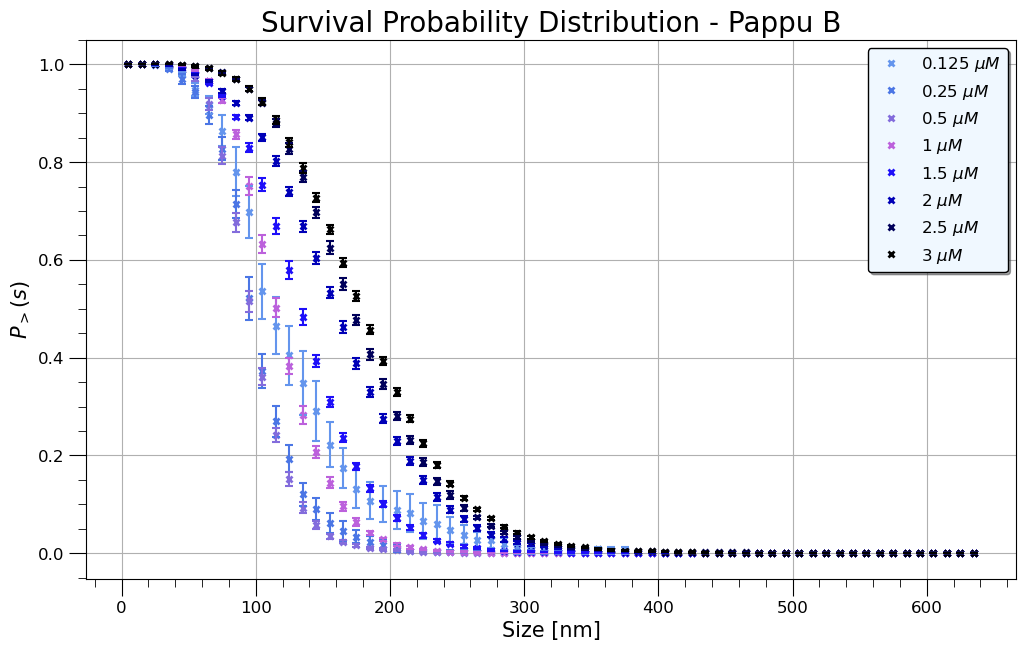

In [8]:
fig, ax = plt.subplots(figsize=(12, 7))



for conc in pappu_b_conc:
    ax.plot(np.array(pappu_b['Size']), final_cum_dict_b[conc]['mean'],\
          label = f'{conc} $ \mu M$', marker = 'x', zorder = 4, markersize = 5, markeredgewidth = 2,
          linestyle='None', color = colors[conc])
   # ax.plot(pappu_b['Size'], final_cum_dict_b[conc]['mean'], markeredgewidth = 5, linestyle = 'None',\
    #         markersize = 7, zorder = 3, marker = 'x', color = 'black')
    
    ax.errorbar(pappu_b['Size'], final_cum_dict_b[conc]['mean'], yerr = final_cum_dict_b[conc]['std'], 
                linestyle='None', fmt='none', capsize=3, capthick=1.5, zorder =5 , color = colors[conc] )

    
ax.legend(facecolor = 'aliceblue', fontsize = 12, shadow = True, edgecolor = 'black')


ax.set_xlabel('Size [nm]', fontsize = 15)
ax.set_ylabel('$P_>(s)$', fontsize = 15)
ax.set_title('Survival Probability Distribution - Pappu B', fontsize = 20)

ax.grid(zorder=1)

ax.tick_params(axis='both', which='major', labelsize=12, length=12)
ax.tick_params(axis='both', which='minor', labelsize=12, length=6)
ax.minorticks_on()

In [9]:
np.random.seed(42)
rand_mean_dict = {conc: pd.DataFrame() for conc in pappu_b_conc}

for conc in pappu_b_conc:
    array_occurances = np.array(pappu_b)
    sizes = np.array(pappu_b['Size'])
    concentration_columns_idx = pappu_b_conc.index(conc) 
    column_occurrances = array_occurances[:,concentration_columns_idx*3 + 1:\
         concentration_columns_idx*3 + 4]

    for i in range(100):
          column_chosen_idx = np.random.choice([0,1,2], 1, p=[1/3, 1/3, 1/3])[0]
          column_chosen = column_occurrances[:, column_chosen_idx]
          rand_mean_dict[conc][f'{i}'] = column_chosen
    


In [10]:
means_dict = {}
std_dict = {}


In [11]:
for conc in pappu_b_conc:
    means_dict[conc] = np.mean(rand_mean_dict[conc], axis = 1)
    std_dict[conc] = np.std(rand_mean_dict[conc], axis = 1)

In [12]:
final_std_pappu_b = pd.DataFrame()
final_std_pappu_b['Size'] = pappu_b['Size']

means_pappu_b = pd.DataFrame(means_dict)
means_pappu_b.columns = list(map(lambda x: x + '_mean', list(means_pappu_b)))
std_pappu_b = pd.DataFrame(std_dict)
std_pappu_b.columns = list(map(lambda x: x + '_std', list(std_pappu_b)))

for i in range(len(pappu_b_conc)):
    final_std_pappu_b[list(means_pappu_b.columns)[i]] = means_pappu_b.iloc[:,i]
    final_std_pappu_b[list(std_pappu_b.columns)[i]] = std_pappu_b.iloc[:,i]

In [13]:
final_std_pappu_b.to_excel('pappuRandom.xlsx', sheet_name='tagged')

In [14]:
std_pappu_b = pd.DataFrame(std_dict)
#std_pappu_b['Size']

In [15]:
#def dict_moment(conc_list, df, pappu_conc, k):
 #   return {conc: np.mean([k_moment_random(df, conc, pappu_conc, k) for _ in range(100)])\
  #  for conc in pappu_conc}
def column_random(df, concentration, pappu_conc):
    array_occurances = np.array(df)
    sizes = np.array(df['Size'])
    concentration_columns_idx = pappu_conc.index(concentration) 
    column_occurrances = array_occurances[:,concentration_columns_idx*3 + 1:\
         concentration_columns_idx*3 + 4]
    
    column_chosen_idx = np.random.choice([0,1,2], 1, p=[1/3, 1/3, 1/3])[0]
    column_chosen = column_occurrances[:, column_chosen_idx]
    return column_chosen



#column_random(pappu_b, '',pappu_b_conc)

In [16]:
critical_c_b = 3


In [17]:
k_to_try = [0.5, 1, 1.5, 2]


k_array_lines_b = []
k_array_std_b = []
for k in k_to_try:
    k_mom = dict_moment(pappu_b_conc, pappu_b, pappu_b_conc, k)
    k_mom_std = dict_moment_std(pappu_b_conc, pappu_b, pappu_b_conc, k)
    k_mom = dict(map(lambda kv: (kv[0], (kv[1])**(-1/k)), k_mom.items()))
    k_array_lines_b.append(k_mom)
    k_array_std_b.append(k_mom_std)

In [18]:
def line(x, a, b):
    return a*x + b

5.491239696686802
5.434240479721565
5.390416367213256
5.361175661755084


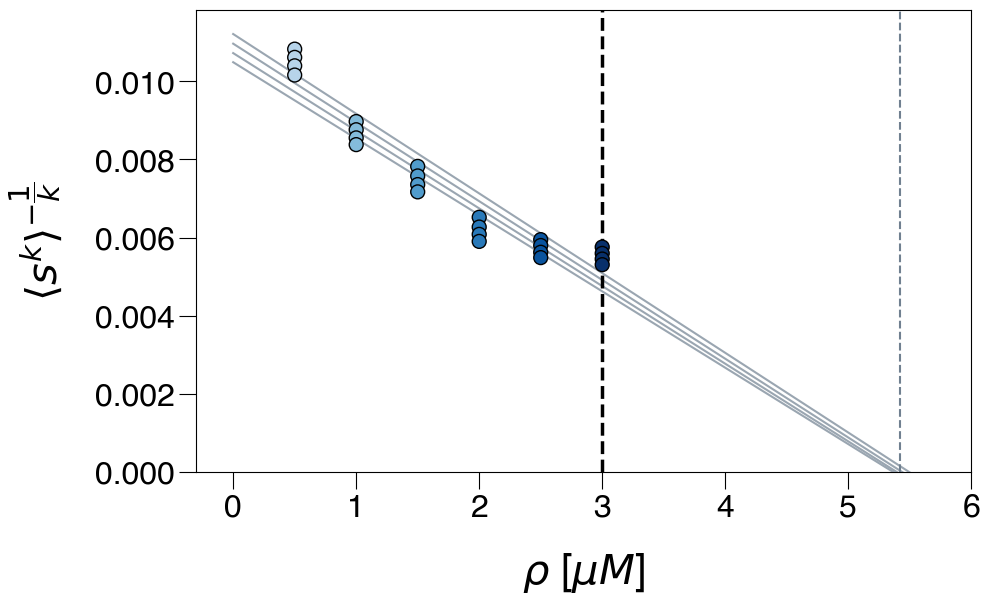

In [19]:
import matplotlib.pyplot as plt 
plt.rc('font', family='Helvetica')
fig, ax = plt.subplots(figsize=(10, int(0.65 * 10)))


slopes_b = {}; intercepts_b = {}; r_b = {}; se_b = {}

x_axis = np.linspace(0, 6, 1000)
rho_c_list= []
var_list_b = []

n_colors = len(pappu_b_conc) - 2
cmap = matplotlib.cm.get_cmap('Blues')
colors = [cmap(np.linspace(0.3, 1, n_colors))[i] for i in range(n_colors)]

for i in range(len(k_to_try)):
    ax.scatter(list(map(lambda x: float(x), list(k_array_lines_b[i].keys())))[2:]\
        , list(k_array_lines_b[i].values())[2:], label = f'k = {k_to_try[i]}', color=colors, 
        alpha=1, zorder=4, edgecolor = 'black', s = 100)


    slope, intercept, r, _, se = \
    linregress(list(map(lambda x: float(x), list(k_array_lines_b[i].keys())))[2:],\
    list(k_array_lines_b[i].values())[2:])

    popt, pcov = curve_fit(line, list(map(lambda x: float(x), list(k_array_lines_b[i].keys())))[1:],\
    list(k_array_lines_b[i].values())[1:])


    var_list_b.append((popt[1]**2 / popt[0]**4) * pcov[0][0] + (1 / popt[1] **2) * pcov[1][1])

    slopes_b[k_to_try[i]] = slope
    intercepts_b[k_to_try[i]] = intercept
    r_b[k_to_try[i]] = r
    se_b[k_to_try[i]] = se
    #ax.axvline(- intercept / slope, linestyle = '--',\
     #   label = f'Inferred Critical concentration, k = {k_to_try[i]}', color=colors[i], zorder=2)

    
    print(- intercept / slope)
    
    rho_c_list.append((- intercept / slope))

    ax.plot(x_axis, slope * x_axis + intercept, label = f'k = {k_to_try[i]} fit', color='slategrey', alpha=0.7, zorder=3)
ax.axvline(critical_c_b, color = 'black', linestyle = '--', label = 'Critical concentration' ,\
     zorder=3, linewidth = 2.5)

ax.axvline(np.mean(rho_c_list), color = 'slategrey', linestyle = '--', label = 'Critical concentration' ,\
     zorder=3)


#ax.legend(facecolor = 'aliceblue', fontsize = 10, shadow = True, edgecolor = 'black')
ax.set_ylim(bottom = 0)
ax.set_xlim(right = 6)

ax.set_xlabel('$\\rho$ [$\mu M$]', fontsize = 30, labelpad = 20)
ax.set_ylabel('$ \left <  s^{k} \\right >^{-\dfrac{1}{k}} $', fontsize = 30, labelpad = 20)
#ax.set_title('Estimation of critical concentration - Pappu B', fontsize = 20)

#ax.grid(zorder=1)

ax.tick_params(axis='both', which='major', labelsize=23, length=12)
#ax.tick_params(axis='both', which='minor', labelsize=12, length=6)
#fig.savefig('../../pdfPlots/FigS3a.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../pdfPlots/FigS3a.svg', dpi = 300, facecolor = 'white')

In [20]:
k =  np.sum(1 / np.array(var_list_b))
y_bar = np.sum(np.array(rho_c_list) / np.array(var_list_b)  ) / k
print(y_bar, 'pm', np.sqrt(1/k))

5.423710303940172 pm 0.3036205985463594


In [21]:
rho_c_mean = np.mean(rho_c_list)

In [22]:
k_to_try = [0.5, 1, 1.5, 2]
critical_c_b_final = rho_c_mean

ratio_arr_list = []
k_mom_list = []
k_mom_1_list = []
k_mom_std = []
k_mom_1_std = []
for k in k_to_try:
    k_mom = dict_moment(pappu_b_conc, pappu_b, pappu_b_conc, k)
    k_mom_list.append(k_mom)
    k_mom_std.append(dict_moment_std(pappu_b_conc, pappu_b, pappu_b_conc, k))
    k_1_mom = dict_moment(pappu_b_conc, pappu_b, pappu_b_conc, k + 1)
    k_mom_1_list.append(k_1_mom)
    k_mom_1_std.append(dict_moment_std(pappu_b_conc, pappu_b, pappu_b_conc, k + 1))

    k_mom_arr = np.array(list(k_mom.values()))
    k_1_mom_arr = np.array(list(k_1_mom.values()))
    ratio_dict = {np.abs((float(conc) - critical_c_b_final)/critical_c_b_final):\
         k_1_mom_arr[i] / k_mom_arr[i] \
        for i, conc in enumerate(pappu_b_conc)}
    ratio_arr_list.append(ratio_dict)

In [23]:
err_dict = {}
for i in range(len(k_to_try)):
    err_dict[k_to_try[i]] = {}
    for conc in pappu_b_conc:
        
        yerr = np.sqrt( (1 / k_mom_1_list[i][conc])**2 * k_mom_1_std[i][conc] ** 2 +\
            (1 / k_mom_list[i][conc])**2 * k_mom_std[i][conc] ** 2)

        err_dict[k_to_try[i]][conc] = yerr

-0.9264696213910443 4.595895698253296 -0.9433125496201454
-0.9391215716279883 4.6386760786370145 -0.9404721799378264
-0.9391569615437642 4.690329125651698 -0.937778700411958
-0.9465910719360244 4.732708657201398 -0.9340478459045601


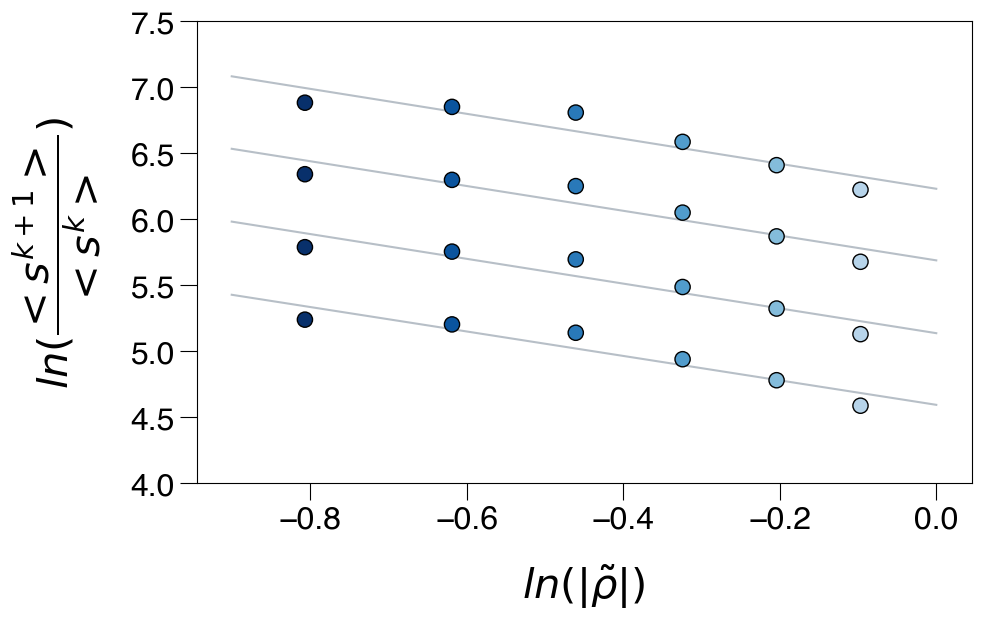

In [24]:
import matplotlib.pyplot as plt 
plt.rc('font', family='Helvetica')
x_axis = np.linspace(-0.9, -0, 100)
fig, ax = plt.subplots(figsize=(10, int(10 * 0.65)))
n_colors = len(pappu_b_conc) - 2
cmap = matplotlib.cm.get_cmap('Blues')
colors = [cmap(np.linspace(0.3, 1, n_colors))[i] for i in range(n_colors)]
from openpyxl import load_workbook
dataToSave = pd.DataFrame({'ln |tho_tilde|':np.log(np.array(list(ratio_arr_list[0].keys())[2:]))})
for i, dict_ in enumerate(ratio_arr_list):
    dataToSave['k = ' + str(k_to_try[i])] = np.log(np.exp(i)  * np.array(list(dict_.values())[2:]))
    ax.scatter(np.log(np.array(list(dict_.keys())))[2:],\
         np.log(np.exp(i/2)*np.array(list(dict_.values())))[2:], zorder = 3, color = colors, label = f'k = {k_to_try[i]}',\
            s = 120, edgecolor = 'black')

    #ax.errorbar(np.log(np.array(list(dict_.keys())))[2:],\
    #        np.log(np.exp(i/2)*np.array(list(dict_.values())))[2:],\
    #        yerr = list(err_dict[k_to_try[i]].values())[2:],\
    #            zorder = 2, color = colors, fmt = 'none', capsize =3, capthick = 1.5)

    # fitting 
    slope, intercept, r, p, se = linregress(np.log(np.array(list(dict_.keys())))[2:],\
            np.log(np.array(list(dict_.values())))[2:])
    print(slope, intercept, r)
    

    ax.plot(x_axis, slope * x_axis + intercept + i/2, color = 'slategrey', alpha = 0.5, zorder = 1)

book = load_workbook('../../siData.xlsx')
writer = pd.ExcelWriter('../../siData.xlsx', engine = 'openpyxl', mode='a')
writer.book = book
dataToSave.to_excel(writer, sheet_name = 'FigSI1B', index = False)
writer.close()
#ax.grid(zorder = 1, which='both')      
#ax.set_xscale('log')  
#ax.set_yscale('log')  
ax.set_ylim(bottom = 4, top = 7.5)
  
#ax.set_title("$ \\varphi$ Estimation - Pappu B", fontsize=25)  
ax.set_xlabel('$ln ( | \\tilde{\\rho}| )$', fontsize = 30, labelpad = 20)  
ax.set_ylabel('$ ln(\dfrac{ <s^{k+1}>}{<s^{k}>})$', fontsize = 30, labelpad = 20)
#ax.legend(facecolor = 'aliceblue', fontsize = 12, edgecolor = 'black', shadow = True)

ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())  
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())  
ax.get_xaxis().set_minor_formatter(mpl.ticker.ScalarFormatter())  
ax.get_yaxis().set_minor_formatter(mpl.ticker.ScalarFormatter())  
ax.tick_params(axis='both', which='major', labelsize=23, length=12)  
#ax.tick_params(axis='both', which='minor', labelsize=10, length=8)

#fig.savefig('../../pdfPlots/FigS1b.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../pdfPlots/FigS1b.svg', dpi = 300, facecolor = 'white')

-0.9264696213910443 4.595895698253296 -0.9433125496201454
-0.9391215716279883 4.6386760786370145 -0.9404721799378264
-0.9391569615437642 4.690329125651698 -0.937778700411958
-0.9465910719360244 4.732708657201398 -0.9340478459045601


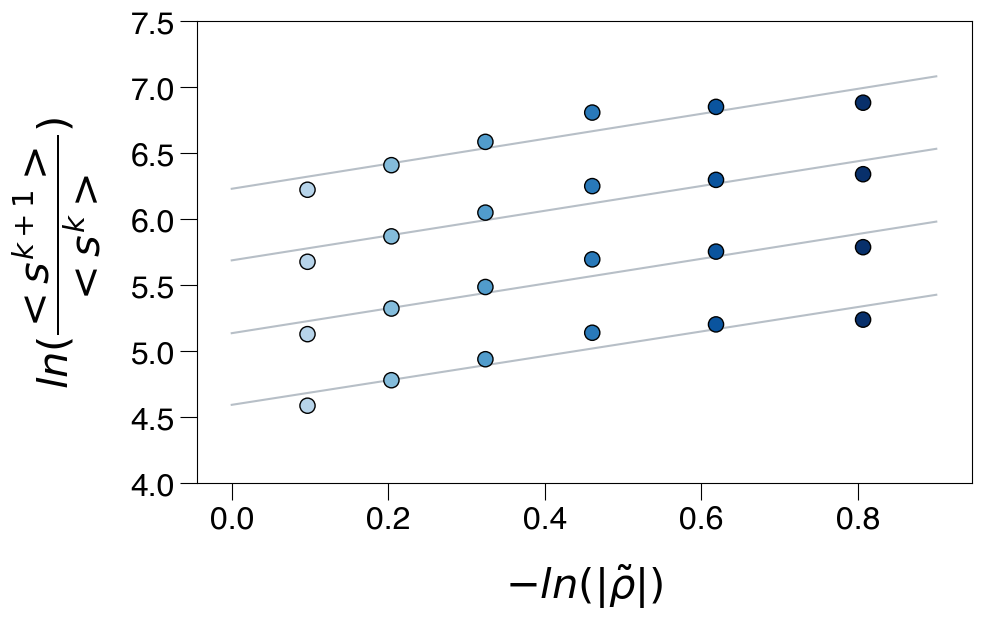

In [26]:
import matplotlib.pyplot as plt 
plt.rc('font', family='Helvetica')
x_axis = np.linspace(-0.9, -0, 100)
fig, ax = plt.subplots(figsize=(10, int(10 * 0.65)))
n_colors = len(pappu_b_conc) - 2
cmap = matplotlib.cm.get_cmap('Blues')
colors = [cmap(np.linspace(0.3, 1, n_colors))[i] for i in range(n_colors)]


for i, dict_ in enumerate(ratio_arr_list):
    ax.scatter(-np.log(np.array(list(dict_.keys())))[2:],\
         np.log(np.exp(i/2)*np.array(list(dict_.values())))[2:], zorder = 3, color = colors, label = f'k = {k_to_try[i]}',\
            s = 120, edgecolor = 'black')

    #ax.errorbar(np.log(np.array(list(dict_.keys())))[2:],\
    #        np.log(np.exp(i/2)*np.array(list(dict_.values())))[2:],\
    #        yerr = list(err_dict[k_to_try[i]].values())[2:],\
    #            zorder = 2, color = colors, fmt = 'none', capsize =3, capthick = 1.5)

    # fitting 
    slope, intercept, r, p, se = linregress(np.log(np.array(list(dict_.keys())))[2:],\
            np.log(np.array(list(dict_.values())))[2:])
    print(slope, intercept, r)
    

    ax.plot(-x_axis, slope * x_axis + intercept + i/2, color = 'slategrey', alpha = 0.5, zorder = 1)


#ax.grid(zorder = 1, which='both')      
#ax.set_xscale('log')  
#ax.set_yscale('log')  
ax.set_ylim(bottom = 4, top = 7.5)
  
#ax.set_title("$ \\varphi$ Estimation - Pappu B", fontsize=25)  
ax.set_xlabel('$-ln ( | \\tilde{\\rho}| )$', fontsize = 30, labelpad = 20)  
ax.set_ylabel('$ln(\dfrac{ <s^{k+1}>}{<s^{k}>})$', fontsize = 30, labelpad = 20)
#ax.legend(facecolor = 'aliceblue', fontsize = 12, edgecolor = 'black', shadow = True)

ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())  
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())  
ax.get_xaxis().set_minor_formatter(mpl.ticker.ScalarFormatter())  
ax.get_yaxis().set_minor_formatter(mpl.ticker.ScalarFormatter())  
ax.tick_params(axis='both', which='major', labelsize=23, length=12)  
#ax.tick_params(axis='both', which='minor', labelsize=10, length=8)

#fig.savefig('../../paperPlots/pdfPlots/FigS1bReversed.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../paperPlots/pdfPlots/FigS1bReversed.svg', dpi = 300, facecolor = 'white')

In [27]:
from  matplotlib.colors import LinearSegmentedColormap
import matplotlib


n_colors = len(pappu_b_conc)
cmap = matplotlib.cm.get_cmap('Blues')
colors = {conc: cmap(np.linspace(0.4, 1, n_colors))[i] for i, conc in enumerate(pappu_b_conc)}

colors_err = {conc: cmap_err(np.linspace(0, 1, n_colors))[i] for i, conc in enumerate(pappu_b_conc)}


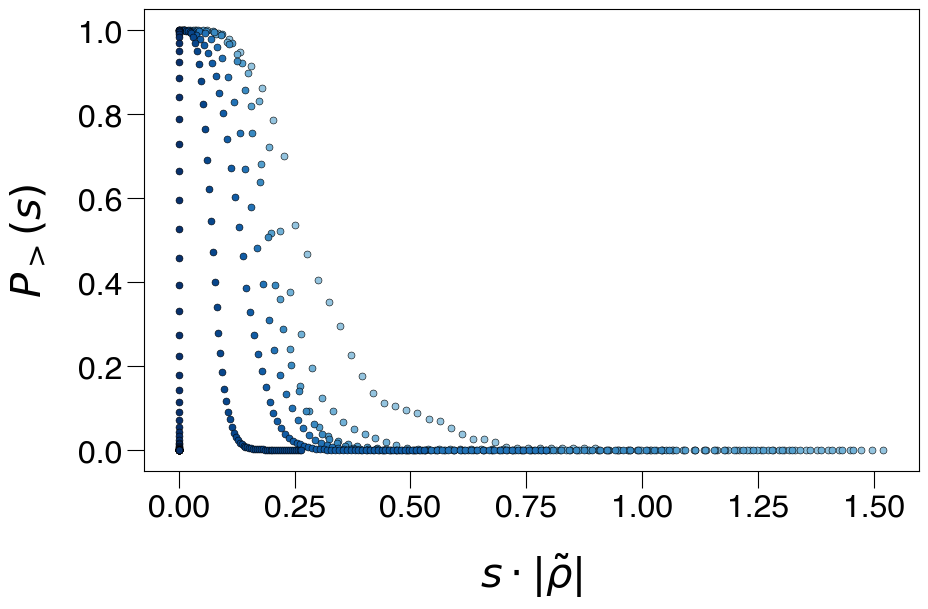

In [28]:
fig, ax = plt.subplots(figsize=(10, int(0.65 * 10)))
import matplotlib.pyplot as plt 
plt.rc('font', family='Helvetica')

for conc in pappu_b_conc:
    ax.scatter(np.array(pappu_b['Size'])*(np.abs((float(conc) - critical_c_b)/(critical_c_b))) /400, 
            final_cum_dict_b[conc]['mean'], label = f'{conc} $ \mu M$', zorder = 4, color = colors[conc], s = 25, edgecolor = 'black',\
                linewidth = 0.4)

    #ax.errorbar(np.array(pappu_b['Size'])*(np.abs((float(conc) - critical_c_b)/(critical_c_b))), final_cum_dict_b[conc]['mean'], yerr = final_cum_dict_b[conc]['std'], 
     #           fmt='none', capsize=3, capthick=1.5, zorder =5 , color = colors[conc] )

    
#ax.legend(facecolor = 'aliceblue', fontsize = 12, shadow = True, edgecolor = 'black')


ax.set_xlabel('$s \cdot | \\tilde{\\rho}|$', fontsize = 30, labelpad = 20)
ax.set_ylabel('$P_>(s)$', fontsize = 30, labelpad = 20)
#ax.set_title('Collapsed Survival Probability Distribution old $\\rho_c$ - Pappu B ', fontsize = 20)



ax.tick_params(axis='both', which='major', labelsize=23, length=12)
#ax.tick_params(axis='both', which='minor', labelsize=12, length=6)
#fig.savefig('../../pdfPlots/FigS3b.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../pdfPlots/FigS3b.svg', dpi = 300, facecolor = 'white')


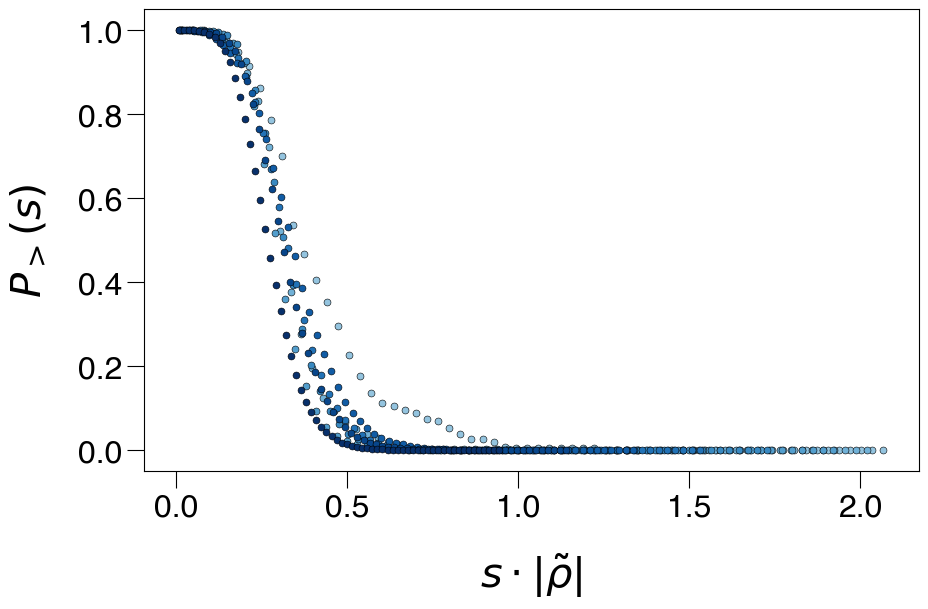

In [29]:
fig, ax = plt.subplots(figsize=(10, int(0.65 * 10)))


for conc in pappu_b_conc:
    ax.scatter(np.array(pappu_b['Size'])*(np.abs((float(conc) - critical_c_b_final)/(critical_c_b_final))/300), 
            final_cum_dict_b[conc]['mean'], label = f'{conc} $ \mu M$', zorder = 4, color = colors[conc], s = 25, edgecolor = 'black',\
                linewidth = 0.4)

    #ax.errorbar(np.array(pappu_b['Size'])*(np.abs((float(conc) - critical_c_b_final)/(critical_c_b_final))), final_cum_dict_b[conc]['mean'], yerr = final_cum_dict_b[conc]['std'], 
     #           fmt='none', capsize=3, capthick=1.5, zorder =5 , color = colors[conc] )

    
#ax.legend(facecolor = 'aliceblue', fontsize = 12, shadow = True, edgecolor = 'black')


ax.set_xlabel('$s \cdot | \\tilde{\\rho}|$', fontsize = 30, labelpad = 20)
ax.set_ylabel('$P_>(s)$', fontsize = 30, labelpad = 20)
#ax.set_title('Collapsed Survival Probability Distribution new $\\rho_c$ - Pappu B ', fontsize = 20)



ax.tick_params(axis='both', which='major', labelsize=23, length=12)
#ax.tick_params(axis='both', which='minor', labelsize=12, length=6)
fig.savefig('../../newCollapse2.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../pdfPlots/FigS3c.svg', dpi = 300, facecolor = 'white')

In [30]:

pd.options.plotting.backend = "plotly"

app = JupyterDash(__name__)

app.layout = html.Div([
        dcc.Slider(min=0, max=10, step=0.1, value=critical_c_b, id ='slider', tooltip={"placement": "bottom", "always_visible": True}),
        html.Button(id='submit-button', type='submit', children='Submit', style={'padding':10,'fontSize':18}),
        html.Div(id='slider-output')], 
                      )

@app.callback(Output('slider-output', 'children'),
             [Input('submit-button', 'n_clicks')],
             [State('slider', 'value')])
                                     
                                     
                                     
def update_output(clicks, slider):
        if clicks is not None:
           
            
            
            
            fig = go.Figure()       
            fig1 = go.Figure()

            k_to_try = np.arange(0, 2, 0.4)
            critical_c_b = 3

            ratio_arr_list = []
            for k in k_to_try:
                k_mom = dict_moment(pappu_b_conc, pappu_b, pappu_b_conc, k)
                k_1_mom = dict_moment(pappu_b_conc, pappu_b, pappu_b_conc, k + 1)

                k_mom_arr = np.array(list(k_mom.values()))
                k_1_mom_arr = np.array(list(k_1_mom.values()))
                ratio_dict = {np.abs((float(conc) - slider)/slider): k_1_mom_arr[i] / k_mom_arr[i] \
                    for i, conc in enumerate(pappu_b_conc)}
                ratio_arr_list.append(ratio_dict)

            for i, dict_ in enumerate(ratio_arr_list):
                #ax.plot(list(dict_.keys()), list(dict_.values()), 'o', label = f'k = {k_to_try[i]}', zorder = 2)
                fig1.add_trace(go.Scatter(x= np.log(np.array(list(dict_.keys()))),\
                     y = np.log(np.array(list(dict_.values()))), mode='markers', name=f'k = {k_to_try[i]}') )
     
            for conc in pappu_b_conc:
                x = cumulative_data(pappu_b_cum_dict_data[conc])[0]
                y = cumulative_data(pappu_b_cum_dict_data[conc])[1]
                fig.add_trace(go.Scatter(x= x * np.abs((float(conc) - slider)/slider),\
                     y = y, mode='markers', name=f'Pappu B, {conc} muM') )

            fig.update_layout(
                title="Collapse",
                xaxis_title="s⋅rho~",
                yaxis_title="P>(s)",
                legend_title="Legend",
                font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="RebeccaPurple"
                )
            )

            

            fig1.update_layout(
                title="phi estimation",
                xaxis_title="rho~",
                yaxis_title="moment's ratio",
                legend_title="Legend",
                font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="RebeccaPurple"
                )
            )
            
            fig.update_layout(font=dict(size=20))
            
            return dcc.Graph(figure=fig), dcc.Graph(figure=fig1)
            
            #return 'You have selected "{}"'.format(slider)




app.run_server(mode='inline')

In [31]:
concentrations = np.array([50, 100, 300])
concentrations_dead = np.array([6.67, 13.33, 26.67, 33.33])

critical_c_dead = 39.292520813456285
critical_c = [100, 700, 700]

sigmas_syn = np.array([0.327, 0.244, 0.384])
scales_syn = np.array([0.0658, 0.0433, 0.0631])

sigmas_dead = np.array([0.7978, 0.9650, 1.3643, 1.3497])
p_eff = [0.88396581, 1.68300937, 1.96221425, 3.96514723, 4.15617441]
scales_dead = np.array([0.49022*p_eff[1], 0.45347*p_eff[2], 0.48037*p_eff[3], 0.50866*p_eff[4]])

exponent_factor = 3

In [32]:
dev_TEM = [-0.2857, 0.42857]

In [33]:
pappu_conc = ['0.125', '0.25','0.5', '1', '2']
sigma_pappu = [0.40421793173349163, 0.32638985000483434, 0.29216658480034813, 0.2915322161234465,\
     0.34770317593036937]
pappu_conc_B = ['0.125', '0.25','0.5', '1', '1.5', '2', '2.5', '3']
sigma_pappu_B = [0.4137385757744504, 0.2732423533811261, 0.27864825014803357, 0.29387658795655214,\
      0.33857214440031735, 0.37283437742444436, 0.3323730503986392, 0.33953835836709134]

In [34]:
colors=np.array(['C0', 'C1', 'C2'])
colors2=np.array(['C3', 'C4', 'goldenrod', 'turquoise'])
x = np.linspace(-1.2, 2, 1000)
#fig, ax = plt.subplots(1,1 , figsize=(15, 10))
dev_list_syn = []
dev_list_dead = []
dev_list_pappu_a = []
dev_list_pappu_b = []
dev_list_new = []
conc_new =[100, 200]

for conc, sigma, scale, crit, color in zip(concentrations, sigmas_syn, scales_syn, critical_c, colors):

    dev = (conc-crit)/crit
    dev_list_syn.append(dev)
    #ax.scatter(x=dev, y=sigma, s=300, label=f'$\\alpha$-Syn {conc} $\mu M$', edgecolor='black', alpha=0.8, color=color,\
    #zorder = 2)

for conc, sigma, scale, color in zip(concentrations_dead, sigmas_dead, scales_dead, colors2):


    dev = (conc-critical_c_dead)/critical_c_dead
    dev_list_dead.append(dev)
    #ax.scatter(x=dev, y=sigma/exponent_factor, s=300, label=f'$RP_3$ {conc} $\mu M$', marker = "D", edgecolor='black', alpha=0.8, color=color,\
    #zorder = 2)

crit_B = critical_c_b_final
crit = 5.010807026376492

for c, s in zip(pappu_conc, sigma_pappu):
    dev = (float(c)-crit)/crit
    dev_list_pappu_a.append(dev)
    #ax.scatter(x=dev, y=s, s=300, label=f'{c} $\mu M$', edgecolor='black', marker = "^", \
    #alpha=0.8,zorder = 2)


for conc, sigma in zip(pappu_conc_B, sigma_pappu_B):
    
    dev = (float(conc)-crit_B)/crit_B
    dev_list_pappu_b.append(dev)
    #ax.scatter(x=dev, y=sigma, s=300, label=f'{conc} $\mu M$', edgecolor='black', marker = ">",\
    #alpha=0.8,zorder = 2)




#ax.legend(edgecolor='black', shadow = True, facecolor='aliceblue', fontsize=15, loc='best')
#ax.set_xlabel('$\\frac{concentration-critical \quad concentation}{critical \quad concentration}$ ', fontsize=30)
#ax.set_ylabel('$\\frac{\\sigma}{\\beta}$', fontsize=30)
#ax.tick_params(axis='both', which='major', labelsize=15, length=15)
#ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
#ax.set_title('Fatness as a function of the deviation from the critical concentration', fontsize=25)

#ax.plot(x , -0.4*x**2 -0.1*x + 0.45, linewidth = 3, color='firebrick', label = 'Fitted Parabola', zorder = 1.5)

#ax.plot(x , generic_func(x, popt_rad[0], popt_rad[1]) , linewidth = 3, color='firebrick', label = 'Fitted Curve', zorder = 1.5)


ax.scatter((100 - 140)/140, 1.1044104906485683/2,  label='100 $\mu M$ - new - 20%', color='black', marker = "P", edgecolor='black', alpha=0.8,  s=300,  zorder = 2)
ax.scatter((200 - 140)/140, 1.178546538308008/2,  label='200 $\mu M$ - new - 20%', color='blue', marker = "P", edgecolor='black', alpha=0.8,  s=300,  zorder = 2)
dev_list_new += [-0.2857] + [0.42857]



#ax.scatter((200 - 200)/200, 0.264742019753338,  label='200 $\mu M$ - new - 15%', color='black', marker = "P", edgecolor='black', alpha=0.8,  s=300,  zorder = 2)




#PD data
#ax.scatter(inv_fatness(0.7466/2), 0.7466/2,  label='pd 6', color='black', marker = "P", edgecolor='black', alpha=0.8,  s=300,  zorder = 2)
#ax.scatter(inv_fatness(0.6948/2), 0.6948/2, label='pd 34', color='mediumblue', marker = "P", edgecolor='black', alpha=0.8,  s=300,  zorder = 2)

#brain and mice data
#ax.scatter(inv_fatness(0.670756/2), 0.670756/2, label='Brain', color='limegreen', marker = "P", edgecolor='black', alpha=0.8,  s=300,  zorder = 2)
#ax.scatter(inv_fatness((0.618*0.9001701193943803)/2), (0.618*0.9001701193943803)/2, label='Mice 1 WT considering volume', color='C0',marker = "X", edgecolor='black', alpha=0.8,  s=300,  zorder = 2)
#ax.scatter(inv_fatness(0.561/2), 0.561/2, label='Mice 1 WT considering surface', color='C1',marker = "X", edgecolor='black', alpha=0.8,  s=300,  zorder = 2)

#ax.legend(edgecolor='black', shadow = True, facecolor='aliceblue', fontsize=15, loc='lower right')
#ax.grid(zorder = 1)

#ax.minorticks_on()

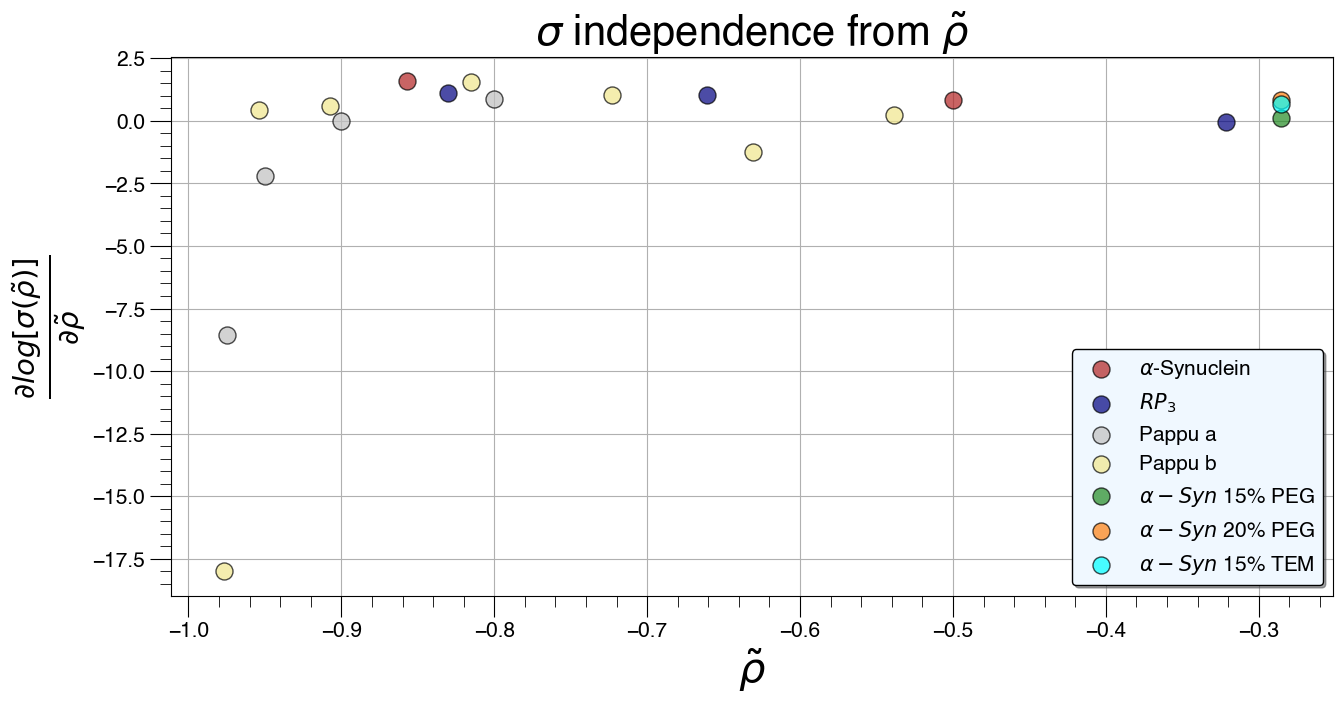

In [35]:
fig, ax = plt.subplots(1, 1, figsize = (15, 7))

for i in range(len(dev_list_syn) - 1):
    if i == 1:
        label = '$\\alpha$-Synuclein'
    else: label = None

    y = (np.log(sigmas_syn[i + 1]) - np.log(sigmas_syn[i]))/(dev_list_syn[i + 1] - dev_list_syn[i])
    x = dev_list_syn[i]
    ax.scatter(x, y, color = 'firebrick', s = 150, alpha = 0.7, edgecolor = 'black', zorder = 2,\
    label = label)


for i in range(len(dev_list_dead) - 1):
    if i == 0:
        label = '$RP_3$'
    else: label = None


    y = (np.log(sigmas_dead[i + 1]) - np.log(sigmas_dead[i]))/(dev_list_dead[i + 1]\
     - dev_list_dead[i])
    x = dev_list_dead[i]
    ax.scatter(x, y, color = 'navy', s = 150, alpha = 0.7, edgecolor = 'black', zorder = 2, label = label)
  

for i in range(len(dev_list_pappu_a) - 1):
    if i == 0:
        label = 'Pappu a'
    else: label = None


    y = (np.log(sigma_pappu[i + 1]) - np.log(sigma_pappu[i]))/(dev_list_pappu_a[i + 1] - dev_list_pappu_a[i])
    x = dev_list_pappu_a[i]
    ax.scatter(x, y, color = 'silver', s = 150, alpha = 0.7, edgecolor = 'black', zorder = 2, label = label)


for i in range(len(dev_list_pappu_b) - 1):
    if i == 0:
        label = 'Pappu b'
    else: label = None


    y = (np.log(sigma_pappu_B[i + 1]) - np.log(sigma_pappu_B[i]))/(dev_list_pappu_b[i + 1] - \
    dev_list_pappu_b[i])
    x = dev_list_pappu_b[i]
    ax.scatter(x, y, color = 'khaki', s = 150, alpha = 0.7, edgecolor = 'black', zorder = 2, label = label)


for i in range(len(dev_list_new) - 1):
    if i == 0:
        label = '$\\alpha-Syn$ 15% PEG'
    else: label = None



    y = (np.log([1.1044104906485683, 1.178546538308008][i + 1]) -\
     np.log([1.1044104906485683, 1.178546538308008][i]))/(dev_list_new[i + 1] - dev_list_new[i])
    x = dev_list_new[i]
    ax.scatter(x, y, color = 'forestgreen', s = 150, alpha = 0.7, edgecolor = 'black', zorder = 2,\
    label =  label)



for i in range(len(dev_list_new) - 1):
    if i == 0:
        label = '$\\alpha-Syn$ 20% PEG'
    else: label = None



    y = (np.log([0.3409415731270552, 0.6171483027968577][i + 1]) -\
     np.log([0.3409415731270552, 0.6171483027968577][i]))/(dev_list_new[i + 1] - dev_list_new[i])
    x = dev_list_new[i]
    ax.scatter(x, y, color = 'C1', s = 150, alpha = 0.7, edgecolor = 'black', zorder = 2,\
    label =  label)


for i in range(len(dev_TEM) -1):
    if i==0:
        label='$\\alpha-Syn$ 15% TEM'
    else : label = None

    y = (np.log([0.196, 0.312][i + 1]) - np.log([0.196, 0.312][i]))/(dev_TEM[i + 1] - dev_TEM[i])

    x = dev_TEM[i]

    ax.scatter(x, y, color = 'aqua', s = 150, alpha = 0.7, edgecolor = 'black', zorder = 2,\
    label =  label)

#x = np.linspace(0.1, 1, 1000)
#ax.plot(x - 1.1, -1/x**(1/2) + 2)
ax.minorticks_on()
ax.set_xlabel('$ \\tilde{\\rho} $ ', fontsize=30)
ax.set_ylabel('$\\frac{\\partial  log[\\sigma(\\tilde{\\rho})]  }\
{\\partial\\tilde{\\rho}}$',\
 fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15, length=15)
ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax.legend(facecolor = 'aliceblue', fontsize = 15, edgecolor = 'black', shadow = True,\
loc = 'lower right')
ax.set_title('$\\sigma$ independence from $\\tilde{\\rho}$', fontsize = 30  )
ax.grid(zorder = 1)

In [36]:
pappu_a_conc = ['0.125', '0.25','0.5', '1', '2']

-0.9769341544253388 -17.986558127575027
-0.9538683088506775 0.424677506082697
-0.9077366177013552 0.5767149955159422
-0.8154732354027102 1.5344905579127115
-0.7232098531040654 1.04480337643752
-0.6309464708054205 -1.2450910203074466
-0.5386830885067756 0.2311745037730512


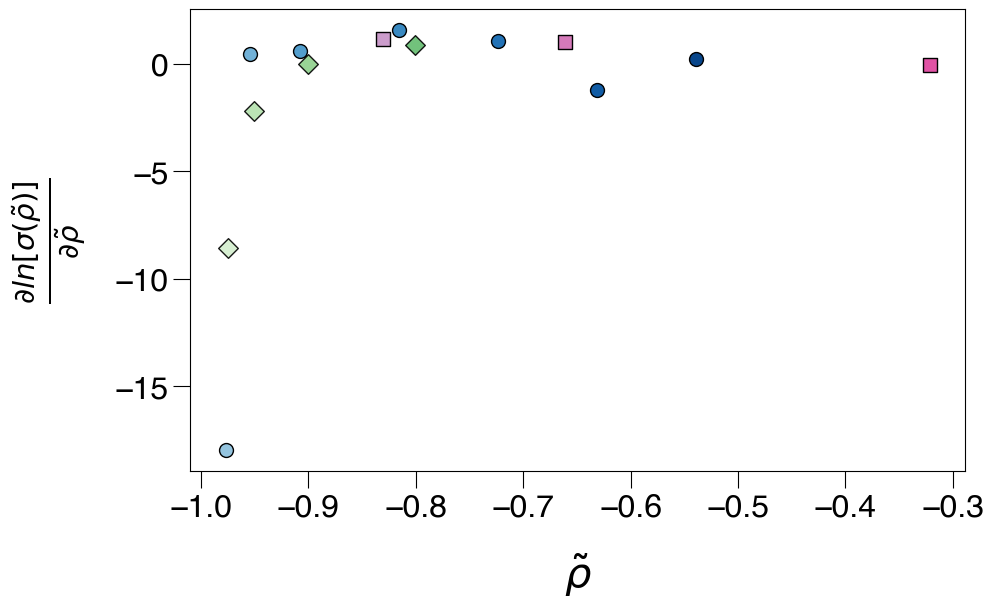

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (10, int(0.65*10))) 
import matplotlib 
import matplotlib.pyplot as plt 
plt.rc('font', family='Helvetica')
# set the font name for a font family 
#plt.rcParams.update({'font.sans-serif':'Helvetica'}) 
import matplotlib.pyplot as plt 
plt.rc('font', family='Helvetica')
cmap = matplotlib.cm.get_cmap('PuRd')
rgba_values = [cmap(np.linspace(0.35, 1, n_colors))[i] for i in range(3)]
n_colors = len(pappu_b_conc)
cmap = matplotlib.cm.get_cmap('Blues')
colors = {conc: cmap(np.linspace(0.4, 1, n_colors))[i] for i, conc in enumerate(pappu_b_conc)}
pappu_a_conc = ['0.125', '0.25','0.5', '1', '2']
n_colors2 = len(pappu_a_conc)

 
 
cmap_err = matplotlib.cm.get_cmap('Greens')
colors2 = {conc: cmap_err(np.linspace(0.2, 1, n_colors))[i] for i, conc in enumerate(pappu_a_conc)}
 


#for i in range(len(dev_list_syn) - 1): 
 #   if i == 1: 
  #      label = '$\\alpha$-Synuclein' 
   # else: label = None 
 
#    y = (np.log(sigmas_syn[i + 1]) - np.log(sigmas_syn[i]))/(dev_list_syn[i + 1] - dev_list_syn[i]) 
 #   x = dev_list_syn[i] 
   # ax.scatter(x, y, color = 'firebrick', s = 150, alpha = 0.7, edgecolor = 'black', zorder = 2,\ 
    #label = label) 
 
 
for i in range(len(dev_list_dead) - 1): 
    if i == 0: 
        label = '$RP_3$' 
    else: label = None 
 
    from openpyxl import load_workbook


    y = (np.log(sigmas_dead[i + 1]) - np.log(sigmas_dead[i]))/(dev_list_dead[i + 1]- dev_list_dead[i]) 
    x = dev_list_dead[i] 
    ax.scatter(x, y, color = rgba_values[i], s = 100, alpha = 1, edgecolor = 'black', 
     zorder = 2, label = label, marker = 's')
    
    '''
    book = load_workbook('../../paperData.xlsx')
    writer = pd.ExcelWriter('../../paperData.xlsx', engine = 'openpyxl', mode='a')
    writer.book = book
    dataToSave.to_excel(writer, sheet_name = 'Fig3RP_3', index = False)
    writer.close()
    '''
for i in range(len(dev_list_pappu_a) - 1): 
    if i == 0: 
        label = 'Pappu a' 
    else: label = None 
 
 
    y = (np.log(sigma_pappu[i + 1]) - np.log(sigma_pappu[i]))/(dev_list_pappu_a[i + 1] - dev_list_pappu_a[i]) 
    x = dev_list_pappu_a[i] 
    ax.scatter(x, y, color = list(colors2.values())[i], s = 100, alpha = 0.9, edgecolor = 'black', 
     zorder = 2, label = label, marker = 'D') 
    
 
for i in range(len(dev_list_pappu_b) - 1): 
    if i == 0: 
        label = 'Pappu b' 
    else: label = None 
 
 
    y = (np.log(sigma_pappu_B[i + 1]) - np.log(sigma_pappu_B[i]))/(dev_list_pappu_b[i + 1] - dev_list_pappu_b[i]) 
    x = dev_list_pappu_b[i] 
    ax.scatter(x, y, color = list(colors.values())[i], s = 100, alpha = 1, edgecolor = 'black', zorder = 2, label = label) 
    print(x, y)
#for i in range(len(dev_list_new) - 1): 
#    if i == 0: 
 #       label = '$\\alpha-Syn$ 15% PEG' 
  #  else: label = None 
 
 
 
 #   y = (np.log([1.1044104906485683, 1.178546538308008][i + 1]) -\ 
  #   np.log([1.1044104906485683, 1.178546538308008][i]))/(dev_list_new[i + 1] - dev_list_new[i]) 
  #  x = dev_list_new[i] 
   # ax.scatter(x, y, color = 'forestgreen', s = 150, alpha = 0.7, edgecolor = 'black', zorder = 2,\ 
    #label =  label) 
 
 
 
#for i in range(len(dev_list_new) - 1): 
 #   if i == 0: 
  #      label = '$\\alpha-Syn$ 20% PEG' 
   # else: label = None 
 
 
 
  #  y = (np.log([0.3409415731270552, 0.6171483027968577][i + 1]) -\ 
   #  np.log([0.3409415731270552, 0.6171483027968577][i]))/(dev_list_new[i + 1] - dev_list_new[i]) 
    #x = dev_list_new[i] 
    #ax.scatter(x, y, color = 'C1', s = 150, alpha = 0.7, edgecolor = 'black', zorder = 2,\ 
    #label =  label) 
 
 
#for i in range(len(dev_TEM) -1): 
 #   if i==0: 
  #      label='$\\alpha-Syn$ 15% TEM' 
   # else : label = None 
 
#    y = (np.log([0.196, 0.312][i + 1]) - np.log([0.196, 0.312][i]))/(dev_TEM[i + 1] - dev_TEM[i]) 
 
#    x = dev_TEM[i] 
 
#    ax.scatter(x, y, color = 'aqua', s = 150, alpha = 0.7, edgecolor = 'black', zorder = 2,\ 
 #   label =  label) 
 
#x = np.linspace(0.1, 1, 1000) 
#ax.plot(x - 1.1, -1/x**(1/2) + 2) 
#ax.minorticks_on() 
 
ax.set_xlabel('$ \\tilde{\\rho} $ ', fontsize=30 , labelpad = 20) 
ax.set_ylabel('$\\frac{\\partial  ln[\\sigma(\\tilde{\\rho})]}{\\partial\\tilde{\\rho}}$', fontsize=30, labelpad=20) 
#ax.set_title("$\\sigma$ independence from $\\tilde{\\rho}$" , fontsize= 30 , pad = 20) 
 
ax.tick_params(axis='both', which='major', labelsize=23, length=12) 
 
 
 
#fig.savefig('../../paperPlots/pdfPlots/Fig3.pdf', dpi=300 , facecolor='white', bbox_inches='tight')
#fig.savefig('../../paperPlots/svgPlots/Fig3.svg', dpi=300 , facecolor='white') 
 
#ax.tick_params(axis='both', which='minor', labelsize=15, length=8) 
#ax.legend(facecolor = 'aliceblue', fontsize = 15, edgecolor = 'black', shadow = True,\ 
#loc = 'lower right') 
#ax.grid(zorder = 1)